<a href="https://colab.research.google.com/github/rakshitshah280701/InstructAware/blob/main/Option_3_Retraining_Using_GPT_3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customization of ChatGPT 3.5 via Fine-Tuning on Vision Output Dataset
* describe the dataset image ocr and output and narratives
* describe what CHATGPT 3.5 size of model
* Where the data is hosted
* connection to openai playground
 * get api key
 * register it as a secret

* role of google drive
 * where the data is
* outline
 * steps going to do in the colab install



####** <font color=red>ASSUMES: all data read/written to /content/drive/MyDrive/InstructAware/REU/Data  directory on drive</font>**

#STEP 0: create base filepath to model directory to save datafiles, etc.

In [ ]:
modelData_file_path = "/content/drive/MyDrive/InstructAware/REU/OpenAI/Data/InstructAware/JSONL"

In [ ]:
import os
jsonl_file_path = os.path.join(modelData_file_path, "structured_dataset1.jsonl")
train_jsonl_path = jsonl_file_path = os.path.join(modelData_file_path, "train_dataset_cleaned.jsonl")
validation_jsonl_path =  os.path.join(modelData_file_path, "validation_dataset_cleaned.jsonl")
test_jsonl_path = os.path.join(modelData_file_path, "test_dataset_cleaned.jsonl")

# Step 1: Install modules

This code cell is required to install the **Hugging Face Datasets** library.

The library provies tools for easily accessing, processing, and managing large-scale datasets that are often used for machine learning (ML), computer vision (CV) & Natrual Langauge Processing (NLP)

* Access to Large Datasets: Provides a hub of ready-to-use datasets for NLP, CV, ML.

* Efficient Loading: Use of memory mapping and streaming to handle large datasets efficiently.
Dataset Processing Tools: Inlcudes utilities for filtering, toeknizing, and transforming datasets.

**What is !pip install?**

**!** is used to run shell commands, **pip install** is necessary because some libraries are not pre-installed.

We use this library to go through the csv files, read, and extract data we need to train the model.


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

### Installing Libraries
📌 Functionality
The Steps:
Install Libraries:
Use pip install to install the required libraries, such as openai, pandas, and tqdm, which help interact with OpenAI's API, handle data, and track progress in your tasks.

* openai: This library allows you to interact with OpenAI's API. It provides functions to perform various tasks, such as uploading files (e.g., .jsonl datasets for fine-tuning), creating fine-tuned models, and making predictions with OpenAI models. It is essential when you are working with the OpenAI ecosystem for tasks like fine-tuning GPT models or querying them.
* pandas: This is a powerful library for data manipulation and analysis. It is widely used for handling structured data (e.g., CSV, JSON, and SQL). pandas allows you to work with data in a tabular format (DataFrames), making it easy to filter, clean, transform, and analyze data.
* tqdm: This is a library for creating progress bars in Python, commonly used when you are processing long-running tasks like iterating over large datasets. It helps visualize the progress of loops and tasks in real time, so you can track how much of the task is complete and how much remains.

In [ ]:
!pip install openai pandas tqdm


# Step 2: API Verification
The code cell below is used to get an API Key from Colab Secrets called "OpenAiKey." The API key is then used to create an OpenAI client and checks if the configuration of the API Key was correct.

**from openai import OpenAI** imports OpenAI's official Python client library, which allows us to interact with OpenAI's API (Application Programming Interface)

We use this service to generate text for our narratives using our datasets.

API key must be protected privately.

In [ ]:
from openai import OpenAI # use 'import openai' instead accoring to ChatGPT
from google.colab import userdata # use 'from google.colab import auth'


# Retrieve API Key from Colab Secrets
client = OpenAI(api_key=userdata.get('OpenAiKey'))
if client:
    print("API key retrieved successfully!")
else:
    raise ValueError("Failed to retrieve the API key. Make sure the secret is configured correctly.")


API key retrieved successfully!


# Step 3: Mounting the Google Drive
📌 Functionality
The Steps:
1. Mount Google Drive:
Use the google.colab library to mount your Google Drive, allowing you to access files stored on your Google Drive directly within the Colab environment.
2. Mount the Drive:
The drive.mount() function will authenticate and mount Google Drive to the specified location (/content/drive), enabling you to read from and write to your Drive files.
* from google.colab import drive: This imports the drive module from the google.colab library, which provides functionality for working with Google Drive in Colab.

* drive.mount('/content/drive'): This command mounts your Google Drive at the specified location (/content/drive) within the Colab environment. When you run this command:

 * Colab will ask you for authorization, so you can connect your Google Drive account to the Colab session.
 * After authorization, the files in your Google Drive will be accessible at /content/drive as if they were part of the local filesystem. You can now read, write, and manipulate files stored in your Google Drive directly in the Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# STEP 3: Data Setup for Fine-Tuning

### import pandas as pd

* **import pandas** imports Pandas library
* **as pd** gives the Pandas library and alias as pd for abbreviation
* **import json** imports Python's built-in **JSON (JavaScript Object Notation) module** which allows us to work with JSON data-a common format for storing exchanging data.
    * For our program, it is used to read JSON files from OpenAI's APIs.
    * Converts JSON to Python objects
    * Converts Python objects to JSON for storage or transmission

### import ast (not currently used)
* Usage of this library allows for safe conversion of a String to a Python Object such a list, dict, tuple etc.
* We need to convert the String created from the dataset into a list so it can be manipulated for our needs.

### from tqdm import tqdm (not currently used)
* **tqdm** stands for **taqaddum** (Arabic for "progress") and is a popular Python library used to add **progress bars** to loops or operations, making it easy to visualize how much work has been completed and how much is remaining.

### Loading Dataset
* To load a dataset you need the file path which is in your Google Drive.
* Then you use the pandas library to read the dataset and store string in variable df

### Normalization
* Parameters include bbox variable, image_width, image_height
    * bbox is used for our bounding box data from our dataset file.
    * image_width & image_height is used in the normalization of our images from the dataset.

# Normalize bounding boxes
if "Bounding Box" in df.columns:
    df["Normalized BBox"] = df["Bounding Box"].apply(normalize_bbox)
* The function normalize_bbox is used to convert the coordinates of the bounding box into a range of 0.0 to 1.0.
* To get the ratio you get the x/y mins and x/y maxs from the bounding box. Then return the ratio by dividing the mins and maxs, by its relative image width and image height.
* The reason to have a range of 0.0 to 1.0 is to ensure the bounding boxes is relative to the image size rather than pixel values of the image.

### Cleaning Ocr Text
* To clean the Ocrs column (gets column df["OCR TEXT"].apply(clean_ocr_text)) it checks if the ocr is a string and if it is it removes unnecessary white spaces.
* If it is not a string then it converts it into a string
* If it catches and error then it gets skipped.

### Grouping Data by Image Name
* df.groupby("Original Filename"): Groups data by the value in the "Original Filename" column
* .agg({}) adds the Original Filename with what is in the agg
 * For "OCR TEXT" and "Normalize BBox" it stores all those values as a list
 * For the rest "Narrative #: first" it takes the first value from each column of corresponding Narrtive
* .reset_index(): coverts the grouped data back into df

### Creating Structured Input
* "\n".join([...]) Combines all lines into a single string with each item appearing on a new line
* f"- '{ocr}' appears at coordinates {bbox}." formats the input to be so that it says that the ocr appears at a specific coordinate.
* for ocr, bbox in zip(row["OCR TEXT"], row["Normalized BBox"]) gets the valuies of ocr and bbox
* Then returns a prompt for what is needed to be generated with the correct relation of OCR and Bounding Box

### Applying the Structured Input
* grouped_data["input_text"] = ...: creates a new column called input_text
* grouped_data.apply(create_input_text, axis=1): the function create_input_text is applied for every grouped_data
 * axis = 1: the function is applied to each row individually

### Grouping Narratives
* grouped_data["output_text"] =: creates a new column called output_text
* grouped_data[["Narrative 1", ...]]: gets the data from those narratives in grouped_data
*  .astype(str): makes sure that the values are strings
* .agg({}) adds the strings of the data of the narrative
* lambda x: applies lambda to each row
* "\n".join(...): joins all formatted narratives into a single string
* [f"Variant {i+1}: {narrative}" for i, narrative in enumerate(x)]:Iterates over each narrative in the row, formats it as "Variant X: <narrative>", and adds it to the final output string.

### Merging Narrative Texts into Output Text
* grouped_data["output_text"] =: Creates a new column named output_text in grouped_data.
* grouped_data[["Narrative 1", "Narrative 2", "Narrative 3", "Narrative 4"]]: Selects columns that contain narrative descriptions.
* .astype(str): Ensures all values are treated as strings (prevents errors if values are NaN or other non-string types).
* .agg(...): Aggregates the narrative strings into a single formatted output.
* lambda x:: Applies the lambda function row-wise.
* "\n".join(...): Joins all formatted narratives into a single string, separating them with a newline.
* [f"Variant {i+1}: {narrative}" for i, narrative in enumerate(x)]: Iterates over each narrative in the row, formats it as "Variant X: <narrative>", and adds it to the final output string.

### Convert to Hugging Face Dataset
* Dataset.from_pandas(...): Converts the grouped_data DataFrame into a Hugging Face dataset.
* grouped_data[["input_text", "output_text"]]: Selects only the relevant columns for fine-tuning.
* .shuffle(seed=42): Randomly shuffles the dataset to ensure a diverse order for training while keeping results reproducible.

### Save as JSONL Format for OpenAI Fine-Tuning
* jsonl_file_path = "/content/dataset_for_finetuning_gpt.jsonl": Defines the file path where the dataset will be saved.
* with open(jsonl_file_path, "w") as jsonl_file: Opens the file in write mode.
* for _, row in grouped_data.iterrows(): Iterates over each row in grouped_data.
* json_record = {...}: Creates a dictionary with input_text and output_text for each row.
* jsonl_file.write(json.dumps(json_record) + "\n"): Converts the dictionary to a JSON string and writes it to the file, ensuring each record is stored as a separate line.

##The Below cell uses dataset with 4 narratives combined together

##The Below Code processes multiple CSV files, where every csv file contains single narrative column, so 4 different csv files to process 4 narratives together.
Before : We trained the model on a single input and single output where the output was combined text of 4 narrative which may cause the model to not learn well and generalise well.

*example:*

input:

*   Task:
  - Generate a natural language description based on detected text and bounding boxes. Detected Text & Locations: - 'CHASE' appears at coordinates [0.3486111111111111, 0.48388888888888887, 0.09583333333333334, 0.04666666666666667]. - 'Vine Street 600-499' appears at coordinates [0.8934027777777778, 0.42, 0.025347222222222222, 0.03944444444444444]. - 'MORTON'S' appears at coordinates [0.5434027777777778, 0.24, 0.0798611111111111, 0.04666666666666667]. - 'MORTON'S' appears at coordinates [0.4017361111111111, 0.28555555555555556, 0.07013888888888889, 0.04611111111111111]. - 'MORTON'S' appears at coordinates [0.2972222222222222, 0.32722222222222225, 0.044444444444444446, 0.03]. Description:
*   output
 - Variant 1: ### Detailed Description You are facing a prominent shop sign for "CHASE," located directly in front of you, indicating a banking establishment. To your extreme right, there's a traffic sign that reads "Vine Street 600-499," which likely provides important navigation information for drivers and pedestrians. Additionally, you can see multiple signs for "MORTON'S" positioned in the center and to the left, indicating a restaurant or dining establishment, with one sign directly in front of you and another slightly to your left. Variant 2: ### Concise Summary In front of you is a "CHASE" bank sign, while to your extreme right, there's a traffic sign for "Vine Street 600-499." You also see several signs for "MORTON'S," indicating a nearby restaurant. Variant 3: ### Simplified Language Right in front of you, there's a sign for "CHASE," a bank. To your right, you can find a traffic sign that mentions "Vine Street 600-499." You also see a few signs for "MORTON'S," which is a restaurant. Variant 4: ### Conversational Tone As you look ahead, you’ll notice the "CHASE" bank sign right in front of you. If you glance to your right, there's a traffic sign that points out "Vine Street 600-499," helping with navigation. You’ll also spot several signs for "MORTON'S," a restaurant, both in front and to your left.






After : Now with the below code we train the model on a single input and single output where the output contains single narrative only and we repeat this process so that we can utilise all the 4 narratives to increase our dataset quantity and help the model to learn and geenralise well

*example*
* input:
  -  Task: Generate a natural language description based on detected text and bounding boxes. Detected Text & Locations: - 'CHASE' appears at coordinates [0.3486111111111111, 0.48388888888888887, 0.09583333333333334, 0.04666666666666667]. - 'Vine Street 400-499' appears at coordinates [0.8934027777777778, 0.42, 0.025347222222222222, 0.03944444444444444]. - 'MORTON'S' appears at coordinates [0.5434027777777778, 0.24, 0.0798611111111111, 0.04666666666666667]. - 'MORTON'S' appears at coordinates [0.4017361111111111, 0.28555555555555556, 0.07013888888888889, 0.04611111111111111]. - 'MORTON'S' appears at coordinates [0.2972222222222222, 0.32722222222222225, 0.044444444444444446, 0.03]. Description:



* Output:
  - You are facing a prominent shop sign for "CHASE," located directly in front of you, indicating a banking establishment. To your extreme right, there's a traffic sign that reads "Vine Street 400-499," which likely provides important navigation information for drivers and pedestrians. Additionally, you can see multiple signs for "MORTON'S" positioned in the center and to the left, indicating a restaurant or dining establishment, with one sign directly in front of you and another slightly to your left.



## Reading JSONL File
* with open(jsonl_file_path, "r") as file:: Opens the JSONL file in read mode.
* for line in file:: Iterates through each line in the file.
* json.loads(line): Converts each line (a JSON string) into a Python dictionary.
* data.append(...): Adds the parsed dictionary to the data list.

### Convert list of JSON into pandas DataFrame
* pd.DataFrame(data): Converts the list of dictionaries into a Pandas DataFrame for easier data manipulation and analysis.

### Display Data
* from IPython.display import display: Imports display() to properly render the DataFrame in Jupyter notebooks.
* display(df): Displays the DataFrame in an interactive format.

In [ ]:
'''
import pandas as pd
import json
import re  # Import regex for text cleaning

# Paths to the four CSV files
csv_files = [
    "/content/drive/MyDrive/InstructAware/REU/Data/narrative_1_updated.csv",
    "/content/drive/MyDrive/InstructAware/REU/Data/narrative_2_updated.csv",
    "/content/drive/MyDrive/InstructAware/REU/Data/narrative_3_updated.csv",
    "/content/drive/MyDrive/InstructAware/REU/Data/narrative_4_updated.csv"
]

final_data = []

# Function to normalize bounding boxes
def normalize_bbox(bbox, image_width=2880, image_height=1800):
    try:
        bbox = json.loads(bbox) if isinstance(bbox, str) else bbox  # Convert JSON string to list
        x_min, y_min, x_max, y_max = bbox
        return [
            x_min / image_width,
            y_min / image_height,
            (x_max - x_min) / image_width,
            (y_max - y_min) / image_height,
        ]
    except:
        return [0, 0, 0, 0]  # Default for errors

# Function to clean output text  For example  removeing 1. 2. 3. )
def clean_output_text(text):
    if not isinstance(text, str):  # Check if text is None or not a string
        return ""  # Return an empty string if text is missing

    # Remove numeric prefixes like "1.", "2.", etc.
    text = re.sub(r"^\d+\.\s*", "", text)

    # Remove descriptive headings like "### Detailed Description"
    text = re.sub(r"###\s*(Detailed Description|Concise Description|Simplified Description|Conversational Tone)\s*", "", text, flags=re.IGNORECASE)

    return text.strip()

# Process each file separately
for file_path in csv_files:
    df = pd.read_csv(file_path)

    # Normalize bounding boxes
    df["Bounding Box"] = df["Bounding Box"].apply(normalize_bbox)

    # Group by 'Original Filename' and aggregate bounding boxes and OCR texts
    grouped_df = df.groupby("Original Filename").agg({
        "OCR TEXT": list,  # Collect OCR texts as a list
        "Bounding Box": list,  # Collect Bounding Boxes as a list
        "Narrative": "first"  # Keep the first narrative for each group
    }).reset_index()

    # Convert grouped data into structured input-output format
    for _, row in grouped_df.iterrows():
        combined_ocr_bbox = "\n".join([
            f"- '{ocr}' appears at coordinates {bbox}." for ocr, bbox in zip(row["OCR TEXT"], row["Bounding Box"])
        ])

        final_data.append({
            "input_text": f"Task: Generate a natural language description based on detected text and bounding boxes.\n\n"
                          f"Detected Text & Locations:\n{combined_ocr_bbox}\n\nDescription:",
            "output_text": clean_output_text(row["Narrative"])  # Apply cleaning function safely
        })

# Save as JSONL file
jsonl_file_path = "/content/drive/MyDrive/InstructAware/REU/Data/structured_dataset1.jsonl"

with open(jsonl_file_path, "w") as jsonl_file:
    for entry in final_data:
        jsonl_file.write(json.dumps(entry) + "\n")

print(f"✅ JSONL file saved at: {jsonl_file_path}")

'''

✅ JSONL file saved at: /content/structured_dataset1.jsonl


In [ ]:
'''
import pandas as pd
import json

# train_dataset_for_finetuning.jsonl
# validation_dataset_for_finetuning.jsonl
# test_dataset_for_finetuning.jsonl
# dataset_for_finetuning_gpt.jsonl
'''jsonl_file_path = os.path.join(modelData_file_path, "structured_dataset1.jsonl")
train_jsonl_path = jsonl_file_path = os.path.join(modelData_file_path, "train_dataset_for_finetuning.jsonl")
validation_jsonl_path =  os.path.join(modelData_file_path, "validation_dataset_for_finetuning.jsonl")
test_jsonl_path = os.path.join(modelData_file_path, "test_dataset_for_finetuning.jsonl")
'''



# Read Data from JSONL file line by line and store it in a list
data = []
with open(jsonl_file_path, "r") as file:
    for line in file:
        data.append(json.loads(line))

# Convert list of JSON objects into a pandas DataFrame
df = pd.DataFrame(data)

from IPython.display import display
display(df)
'''

,input_text,output_text
0,Task: Generate a natural language description ...,"You are facing a prominent shop sign for ""CHAS..."
1,Task: Generate a natural language description ...,"To your left, you will see a prominent sign th..."
2,Task: Generate a natural language description ...,"To your left, you will see a prominent sign fo..."
3,Task: Generate a natural language description ...,"In front of you, there are several signs adver..."
4,Task: Generate a natural language description ...,"To your extreme left, there is a ""No Parking A..."
...,...,...
3419,Task: Generate a natural language description ...,"Right ahead, you’ll notice a sign that tells y..."
3420,Task: Generate a natural language description ...,"On your right, there's a sign advertising whol..."
3421,Task: Generate a natural language description ...,"As you look ahead, there's a sign reminding dr..."
3422,Task: Generate a natural language description ...,"You’re in a delightful area with ""DO-RITE DONU..."


## Upgrading openai Library
📌 Functionality
The Steps:
Upgrade the OpenAI Library:

Use pip to upgrade the openai library to the latest version available, ensuring you have the newest features and bug fixes.
Upgrade the OpenAI Library:

The --upgrade flag will check if there’s a newer version of openai and install it if needed.

* !pip install --upgrade openai: This command upgrades the openai package to the latest version. When you run this command:

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.1/599.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.69.0
    Uninstalling openai-1.69.0:
      Successfully uninstalled openai-1.69.0


## STEP 3.1 - Perform training-validation-test split

Make sure you define the percentage split as parameter so they can be modified easily.

Calculate the split indexes
train_percent = 0.9 (90% training)
validation_split_percent = 0.05 (5% validation)
training split percent = remaining percent (here 5%)




**Functionality:** This code reads exisitng JSONL(JavaScript Object Notation Lines) file, reformats data in each line, and then saves it to a new JSONL file.



1.  **Imports:**
*   json: To handle readin and writing JSON data
*   random: Used to randomly select lines of data for trainig, testing, and validation

2.  **Paths:**
*   Paths for the input (input_jsonl_path) and output (output_jsonl_path) JSONL files are defined.

3.   **Reading the Input JSONL File:**
*   The code opens the iput JSONL file and reads it line by line
*   Each line is assumed to contains a JSON object with input_text and output_text keys
4.  **Reformatting the Data:**
*   For each line, the code constructs a new dictionay called jsonl_entry following the format of:

        {
          "messages": [
              {"role": "system", "content": "You generate detailed narratives from text."},
              {"role": "user", "content": data["input_text"]},
              {"role": "assistant", "content": data["output_text"]}
          ]
        }
*   The input_text and output_text from the original entry are added as the user and assistant messages, respectively.
*   A "system" message is also included, with a fixed message: "You generate detailed narratives from text."
5.  **Saving the Reformatted Data:**
*    The code then writes the reformatted entries to the new JSONL file, one per line.
6.  **Final Message:**
*    After saving, program will print a success message indicating the output file's path.



#NEW -read already split data from datafile paths defined at start of colab

In [ ]:
import json

# File paths

'''
jsonl_file_path = os.path.join(modelData_file_path, "structured_dataset1.jsonl")
train_jsonl_path = jsonl_file_path = os.path.join(modelData_file_path, "train_dataset_for_finetuning.jsonl")
validation_jsonl_path =  os.path.join(modelData_file_path, "validation_dataset_for_finetuning.jsonl")
test_jsonl_path = os.path.join(modelData_file_path, "test_dataset_for_finetuning.jsonl")
'''

# Function to load JSONL data
def load_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load the data
train_data = load_jsonl(train_jsonl_path)
validation_data = load_jsonl(validation_jsonl_path)
test_data = load_jsonl(test_jsonl_path)


# Print top 10 entries for each
print("\nTop 10 entries in Train Data:")
for entry in train_data[:20]:
    print(entry)

print("\nTop 10 entries in Validation Data:")
for entry in validation_data[:20]:
    print(entry)

print("\nTop 10 entries in Test Data:")
for entry in test_data[:20]:
    print(entry)



Top 10 entries in Train Data:
{'messages': [{'role': 'system', 'content': 'You generate detailed narratives from text.'}, {'role': 'user', 'content': "Task: Generate a natural language description based on detected text and bounding boxes.\n\nDetected Text & Locations:\n- 'STOP' appears at coordinates [0.5649305555555556, 0.42388888888888887, 0.07465277777777778, 0.13111111111111112].\n- 'ONE WAY' appears at coordinates [0.5583333333333333, 0.36444444444444446, 0.08784722222222222, 0.06277777777777778].\n- 'CRISTINA GRAJALES' appears at coordinates [0.41215277777777776, 0.33611111111111114, 0.07361111111111111, 0.0661111111111111].\n- 'ONE WAY' appears at coordinates [0.725, 0.5427777777777778, 0.03888888888888889, 0.025555555555555557].\n\nDescription:"}, {'role': 'assistant', 'content': 'As you look ahead, you’ll see a "STOP" sign, reminding you to pause before proceeding. Just above it, a "ONE WAY" sign indicates that traffic flows in a single direction, and there\'s another one to

In [ ]:
'''
# import json
# import random

# # Path to your existing JSONL file
# input_jsonl_path = "/content/dataset_for_finetuning_gpt.jsonl"  # Update this
# output_jsonl_path = "/content/fixed_dataset_for_finetuning.jsonl"

# # Read and reformat JSONL data


import json
import random

# Path to your existing JSONL file
input_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/Data/structured_dataset1.jsonl"  # Update this
train_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/Data/train_dataset_for_finetuning.jsonl"
validation_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/Data/validation_dataset_for_finetuning.jsonl"
test_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/Data/test_dataset_for_finetuning.jsonl"

# Read and reformat JSONL data
jsonl_data = []
with open(input_jsonl_path, "r") as f:
    for line in f:
        data = json.loads(line.strip())

        # Assuming current format is {'input_text': ..., 'output_text': ...}
        jsonl_entry = {
            "messages": [
                {"role": "system", "content": "You generate detailed narratives from text."},
                {"role": "user", "content": data["input_text"]},
                {"role": "assistant", "content": data["output_text"]}
            ]
        }
        jsonl_data.append(jsonl_entry)

# Shuffle the data randomly to ensure a good split
random.shuffle(jsonl_data)

# Calculate the split indexes
train_percent = 0.9
validation_split_percent = 0.05

train_size = int(train_percent * len(jsonl_data))
validation_size = int(validation_split_percent * len(jsonl_data))
# add saftey checks if statements
test_size = len(jsonl_data) - train_size - validation_size

# Split the data
train_data = jsonl_data[:train_size]
validation_data = jsonl_data[train_size:train_size + validation_size]
test_data = jsonl_data[train_size + validation_size:]

# Save the training, validation, and test datasets to separate files
with open(train_jsonl_path, "w") as f:
    for entry in train_data:
        f.write(json.dumps(entry) + "\n")

with open(validation_jsonl_path, "w") as f:
    for entry in validation_data:
        f.write(json.dumps(entry) + "\n")

with open(test_jsonl_path, "w") as f:
    for entry in test_data:
        f.write(json.dumps(entry) + "\n")

print(f"✅ Training dataset saved at: {train_jsonl_path}")
print(f"✅ Validation dataset saved at: {validation_jsonl_path}")
print(f"✅ Test dataset saved at: {test_jsonl_path}")

'''

✅ Training dataset saved at: /content/train_dataset_for_finetuning.jsonl
✅ Validation dataset saved at: /content/validation_dataset_for_finetuning.jsonl
✅ Test dataset saved at: /content/test_dataset_for_finetuning.jsonl


## STEP 3.2 Upload Data to OPenAI

 This code will take the json_data array of data and uploads it to OpenAI as a filename. You will instead have three arrays, one for training, one for testing and one for validation

You will need to upload training and validation files both to OpenAI.

###Uploading a JSONL Dataset to OpenAI for Fine-Tuning

This script uploads a `.jsonl` dataset to OpenAI for fine-tuning.

---

### 📌 Functionality

The Steps:
1. Loads a JSONL dataset from the specified path.
2. Authenticates with OpenAI using an API key.
3. Uploads the dataset to OpenAI's servers.
4. Retrieves and prints the file ID for tracking.

---
**Upload the Dataset**
* file=open(jsonl_path, "rb"): Opens the file in binary mode for upload.
* purpose="fine-tune": Specifies that the file will be used for fine-tuning.

**Retrieve File ID**
* response.id: Extracts the file ID from OpenAI's response.
* print(...): Displays a success message with the file ID.


In [ ]:
import openai

'''
jsonl_file_path = os.path.join(modelData_file_path, "structured_dataset1.jsonl")
train_jsonl_path = jsonl_file_path = os.path.join(modelData_file_path, "train_dataset_for_finetuning.jsonl")
validation_jsonl_path =  os.path.join(modelData_file_path, "validation_dataset_for_finetuning.jsonl")
test_jsonl_path = os.path.join(modelData_file_path, "test_dataset_for_finetuning.jsonl")
'''
# input_jsonl_path = "/content/dataset_for_finetuning_gpt.jsonl"  # Update this
# train_jsonl_path = "/content/train_dataset_for_finetuning.jsonl"
# validation_jsonl_path = "/content/validation_dataset_for_finetuning.jsonl"
# test_jsonl_path = "/content/test_dataset_for_finetuning.jsonl"

openai.api_key = userdata.get("OpenAiKey")


# Upload Training Data
# Upload the file to OpenAI (new API method)
response = openai.files.create(
    file=open(train_jsonl_path, "rb"),
    purpose="fine-tune"
)

# Get the file ID
train_file_id = response.id
print(f"✅ Train Dataset uploaded successfully! File ID: {train_file_id}")


# Upload Validation Data
# Upload the file to OpenAI (new API method)
response = openai.files.create(
    file=open(validation_jsonl_path, "rb"),
    purpose="fine-tune"
)

# Get the file ID
validation_file_id = response.id
print(f"✅ Validation Dataset uploaded successfully! File ID: {validation_file_id}")


# Upload  Testing Data
# Upload the file to OpenAI (new API method)
response = openai.files.create(
    file=open(test_jsonl_path, "rb"),
    purpose="fine-tune"
)

# Get the file ID
testing_file_id = response.id
print(f"✅ Testing Dataset uploaded successfully! File ID: {testing_file_id}")

# file-Dpynf7z9vidp7GuH1dR4V6
# file-H18YhjqSdtJYt45dBvDRgX

✅ Train Dataset uploaded successfully! File ID: file-Dpynf7z9vidp7GuH1dR4V6
✅ Validation Dataset uploaded successfully! File ID: file-H18YhjqSdtJYt45dBvDRgX
✅ Testing Dataset uploaded successfully! File ID: file-ACNFVofcprpMFZ322SKkYq


In [ ]:

'''
import openai

# input_jsonl_path = "/content/dataset_for_finetuning_gpt.jsonl"  # Update this
# train_jsonl_path = "/content/train_dataset_for_finetuning.jsonl"
# validation_jsonl_path = "/content/validation_dataset_for_finetuning.jsonl"
# test_jsonl_path = "/content/test_dataset_for_finetuning.jsonl"

# Path to your JSONL file
jsonl_path = "/content/fixed_dataset_for_finetuning.jsonl"
openai.api_key = userdata.get("OpenAiKey")

# Upload the file to OpenAI (new API method)
response = openai.files.create(
    file=open(jsonl_path, "rb"),
    purpose="fine-tune"
)

# Get the file ID
file_id = response.id
print(f"✅ Dataset uploaded successfully! File ID: {file_id}")

'''

FileNotFoundError: [Errno 2] No such file or directory: '/content/fixed_dataset_for_finetuning.jsonl'



#STEP 4 🚀 Fine-Tuning GPT-3.5/4 with Validation in OpenAI

This script fine-tunes OpenAI's `gpt-3.5-turbo` (or `gpt-4`) using a **training and validation dataset**.

## 📌: Steps:
1. **Upload the training and validation dataset** as `.jsonl` files to OpenAI.
2. **Replace the file IDs** in the code.
3. **Run the script** to start fine-tuning.
4. **Monitor training & validation loss** dynamically.
---
**Functionality**: This Python code uses OpenAI's API to fine-tune a model using a training file and a validation file, and then monitors the fine-tuning job until completion. Below is a detailed explanation of each part of the code:

**Imports:**
* **openai**: The OpenAI Python client, used to interact with the OpenAI API.
* time: The time module is used to create pauses (delays) in the code execution, allowing for periodic status checks.

**Variables**:
* **training_file_id**: This is the ID of the training file (a file containing data used to train the model). You need to replace the placeholder with the actual ID of the file you're using for training.
* **validation_file_id**: This is the ID of the validation file (a file containing data used to evaluate the model's performance during training). Similarly, replace this placeholder with the actual ID of your validation file.
base_model: The base model you want to fine-tune. In this case, it's set to gpt-3.5-turbo, but you can change it to gpt-4 if necessary.

**Fine-tuning Request**:
* The **openai.fine_tuning.jobs.create()** method starts the fine-tuning process. It sends a request to OpenAI’s API to initiate fine-tuning using the provided training and validation files and the selected base model.
  * **training_file**: The ID of the training file.
  * **validation_file**: The ID of the validation file (important for tracking how well the model is performing during training).
  * model: The base model to be fine-tuned (gpt-3.5-turbo in this case).
* The response from the API contains the job ID, which is saved to the job_id variable for future reference.

**Job Monitoring**:
* A loop is used to periodically check the fine-tuning job's status.
* openai.fine_tuning.jobs.retrieve(job_id): This retrieves the current status of the fine-tuning job using the job ID.
* status: The current status of the job (e.g., pending, in_progress, succeeded, failed, etc.).
* Metrics: If available, the job’s metrics, such as training and validation loss, are displayed. These metrics help track the model’s performance during fine-tuning.
  * Training loss: Indicates how well the model is learning from the training data.
  * Validation loss: Indicates how well the model is performing on unseen data (the validation set).

**Checking Job Completion**:
* The code continues to check the job status every 60 seconds (**time.sleep(60)**) until the job reaches one of the final states: succeeded, failed, or cancelled.
* If the job is completed (i.e., status is succeeded), the fine-tuned model’s name is retrieved from the job_status object.
* If the fine-tuning job is successful, the model name is printed; if it failed or was cancelled, an error message is shown.

**Final Output**:
* If the job succeeded, the fine-tuned model's name (fine_tuned_model) is displayed.
* If the job failed or was cancelled, a warning message is displayed instead.

**Key Points**:
* Fine-tuning is an iterative process, and this code monitors the status and tracks progress.
* Using a validation file helps ensure that the model generalizes well and avoids overfitting to the training data.
* The code includes checks to display training and validation losses for more transparency into how the fine-tuning is progressing.
---

```python
import openai
import time

# Define your uploaded file IDs (replace with actual validation file ID)
training_file_id = "file-HijQNGKAUThFKd9sTfA42y"  # Replace with actual training file ID
validation_file_id = "file-VALIDATION_FILE_ID"  # Replace with actual validation file ID

# Choose the base model for fine-tuning
base_model = "gpt-3.5-turbo"  # You can change to "gpt-4" if needed

# Start the fine-tuning job with validation
response = openai.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,  # Added validation file
    model=base_model
)

# Get the job ID
job_id = response.id
print(f"🚀 Fine-tuning started! Job ID: {job_id}")

# Monitor fine-tuning progress with validation tracking
while True:
    job_status = openai.fine_tuning.jobs.retrieve(job_id)
    status = job_status.status
    print(f"🔄 Fine-tuning status: {status}")

    # Retrieve training and validation loss if available
    if hasattr(job_status, "metrics"):
        metrics = job_status.metrics
        training_loss = metrics.get("training_loss", "N/A")
        validation_loss = metrics.get("validation_loss", "N/A")
        print(f"📉 Training Loss: {training_loss} | 📊 Validation Loss: {validation_loss}")

    if status in ["succeeded", "failed", "cancelled"]:
        break  # Stop checking when the job finishes

    time.sleep(60)  # Wait for 1 minute before checking again

# Retrieve the fine-tuned model name
if status == "succeeded":
    fine_tuned_model = job_status.fine_tuned_model
    print(f"🎉 Fine-tuned model is ready! Model name: {fine_tuned_model}")
else:
    print("⚠️ Fine-tuning failed or was cancelled.")






# STEP 4: Fine-Tuning GPT-3.5/4 with OpenAI

This script fine-tunes OpenAI's `gpt-3.5-turbo` (or `gpt-4`) using an uploaded dataset.

---
**Choose Base Model**
* base_model: Defines which OpenAI model to fine-tune.
* print(...): Confirms the selected model.

**Fine Tuning**
* openai.fine_tuning.jobs.create(...): Initiates the fine-tuning job.
* training_file=file_id: Uses the specified dataset file.
* model=base_model: Fine-tunes the chosen base model.
* job_id = response.id: Retrieves and stores the fine-tuning job ID.
* print(...): Displays confirmation of the job start.

**Monitor Fine-Tuning Progress**
* openai.fine_tuning.jobs.retrieve(job_id): Retrieves the job’s current status.
* status: Stores the job state (pending, in_progress, succeeded, failed, etc.).
* print(...): Displays the current fine-tuning status.
* if status in ["succeeded", "failed", "cancelled"]:: Stops checking once the job is finished.
* time.sleep(60): Waits 60 seconds before checking again.

**Retrieve Fine-Tuned Model Name**
* if status == "succeeded":: Checks if the fine-tuning process was successful.
* fine_tuned_model = job_status.fine_tuned_model: Retrieves the fine-tuned model’s name.
* print(...): Displays the model name if successful or an error message if failed.

The following cell will print out the job id of any existing jobs.

In [ ]:
import openai

def list_openai_jobs(limit=10):
    jobs = openai.fine_tuning.jobs.list(limit=limit) # add limit to list function
    return jobs.data # access the data attribute directly

# Fetch and display job IDs
job_list = list_openai_jobs(limit=10)
for job in job_list:
    # Access attributes using dot notation (.) instead of subscripting
    print(f"Job ID: {job.id}, Status: {job.status}")
    openai.fine_tuning.jobs.cancel(job.id)
    print(f"Job ID: {job.id}, Status: {job.status}")


Job ID: ftjob-0o0F6fPnZFCI750RzMMT6d2O, Status: succeeded


BadRequestError: Error code: 400 - {'error': {'message': 'Job has already completed: ftjob-0o0F6fPnZFCI750RzMMT6d2O', 'type': 'invalid_request_error', 'param': 'fine_tune_id', 'code': 'invalid_cancel'}}

Click on this in order to open the dashboard to see the code run
https://platform.openai.com/chat-completions

In [ ]:
import openai
import time

#have train, validation (and test) file ids from uploaded data from previous cell

# Choose the base model for fine-tuning
base_model = "gpt-3.5-turbo"  # You can change to "gpt-4" if needed

# Start the fine-tuning job with validation
response = openai.fine_tuning.jobs.create(
    training_file=train_file_id,
    validation_file=validation_file_id,  # Added validation file
    model=base_model,
    hyperparameters={
    "n_epochs": 2,
    "batch_size": "auto",
    "learning_rate_multiplier": "auto",
  }
)

# Get the job ID
job_id = response.id
print(f" Fine-tuning started! Job ID: {job_id}")

# Monitor fine-tuning progress with validation tracking
while True:
    job_status = openai.fine_tuning.jobs.retrieve(job_id)
    status = job_status.status
    print(f" Fine-tuning status: {status}")

    # Retrieve training and validation loss if available
    if hasattr(job_status, "metrics"):
        metrics = job_status.metrics
        training_loss = metrics.get("training_loss", "N/A")
        validation_loss = metrics.get("validation_loss", "N/A")
        print(f" Training Loss: {training_loss} | Validation Loss: {validation_loss}")

    if status in ["succeeded", "failed", "cancelled"]:
        break  # Stop checking when the job finishes

    time.sleep(60)  # Wait for 1 minute before checking again

# Retrieve the fine-tuned model name
if status == "succeeded":
    fine_tuned_model = job_status.fine_tuned_model
    print(f" Fine-tuned model is ready! Model name: {fine_tuned_model}")
else:
    print(" Fine-tuning failed or was cancelled.")

 Fine-tuning started! Job ID: ftjob-5ID4UsHNmzc0zho7vsEeqBAD
 Fine-tuning status: validating_files
 Fine-tuning status: validating_files
 Fine-tuning status: validating_files
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning status: running
 Fine-tuning 

In [ ]:
import openai

def fetch_fine_tuning_logs(job_id):
    logs = openai.fine_tuning.jobs.list_events(job_id)
    return logs.data  # Access the 'data' attribute using dot notation

logs = fetch_fine_tuning_logs("ftjob-5ID4UsHNmzc0zho7vsEeqBAD")

In [ ]:
info = logs[len(logs) -1]
type(info)
info.message

'Step 1525/1541: training loss=0.60'

## STEP 4.1 (OPTIONAL) Retrieve Fine-Tuning Job Status

This script retrieves the status of a fine-tuning job using OpenAI's API.

---
**job_id**
* Specifies the fine-tuning job ID assigned by OpenAI.

**Retrieve Job Details**
* openai.fine_tuning.jobs.retrieve(job_id): Fetches details about the fine-tuning job.
* job_details.status: Retrieves the current status (pending, in_progress, succeeded, or failed).
* print(...): Displays the job's current status.

**Check for Errors (If Job Failed)**
* if job_details.status == "failed":: Checks if the job failed.
* job_details.error: Retrieves the failure reason.
* print(...): Displays an error message if the job failed.

In [ ]:


# Your fine-tuning job ID
job_id = "ftjob-5ID4UsHNmzc0zho7vsEeqBAD"  # Replace with the actual job ID

# Retrieve the job details
job_details = openai.fine_tuning.jobs.retrieve(job_id)

# Print the status and error message (if any)
print("🔍 Job Status:", job_details.status)
if job_details.status == "failed":
    print("❌ Error Reason:", job_details.error)  # Shows the failure reason


🔍 Job Status: succeeded


# STEP 5: Generating Text with a Fine-Tuned OpenAI Model

This script uses a fine-tuned `gpt-3.5-turbo` model to generate natural language descriptions based on detected text and bounding box coordinates.

---
**Set API Key**
* openai.api_key: Retrieves the API key stored in userdata

**Define Fine-Tuned Model**
* model_name: Specifies the fine-tuned model to use.
* print(...): Confirms the selected model.

**Define Input Messages**
* messages: Defines the conversation history for the model.
* role: "system": Provides instructions for how the model should behave.
* role: "user": Supplies the user input, which includes detected text and bounding box coordinates.

**Initialize OpenAI Client**
* client = openai.OpenAI(...): Initializes an OpenAI client with authentication.

**Generate a Response**
* client.chat.completions.create(...): Sends the request to OpenAI.
* model=model_name: Specifies the fine-tuned model.
* messages=messages: Provides the input text.
* temperature=0.9: Adjusts randomness (higher values make responses more creative).

**Retrieve and Print Response**
* response.choices[0].message.content: Extracts the generated text.
* print(...): Displays the output.

## Option 1 - One Prediction
starting cell -- one prediction on hardcoded data sample

In [ ]:
import openai

openai.api_key = userdata.get("OpenAiKey")

# The fine_tuned_model will be defined at the end of fine tuning if you are coming
# back to the cell to run it after it ended you will need to look up the name of
# the model from the dashboard which can be found at https://platform.openai.com/chat-completions
model_name = "ft:gpt-3.5-turbo-0125:ilab::B8dLHiDw"

messages=[
        {"role": "system", "content": "You generate detailed narratives from text."},
        {"role": "user", "content": """Task: Generate a natural language description based on detected text and bounding boxes.

Detected Text & Locations:
-'ONLY' appears at coordinates [0.334375, 0.47833333333333333, 0.01875, 0.04055555555555555].
- 'STOP HERE ON RED' appears at coordinates [0.7277777777777777, 0.575, 0.02847222222222222, 0.06333333333333334].
-'ONLY' appears at coordinates [0.43125, 0.4666666666666667, 0.021527777777777778, 0.042222222222222223].
-'LIFE LifeCenter>' appears at coordinates [0.15069444444444444, 0.2288888888888889, 0.078125, 0.03944444444444444].

Description:"""}
    ]
# Use the new OpenAI API method
client = openai.OpenAI(api_key=userdata.get("OpenAiKey"))  # Initialize the new client

response = client.chat.completions.create(
    model=model_name,
    messages=messages,
    temperature=0.9
)


# Correct way to extract the generated response
print(response.choices[0].message.content)


Variant 1: 1. To your left, there is a traffic sign that reads "ONLY," indicating a specific road rule or restriction. In the center of your view, a similar sign also says "ONLY," likely serving a similar purpose. On your right, you will find a larger sign that instructs drivers to "STOP HERE ON RED," which is crucial for traffic safety.
Variant 2: 2. You have a "STOP HERE ON RED" sign to your right, which is important for traffic safety. Additionally, there are two "ONLY" signs, one on your left and one in the center, indicating specific rules or restrictions.
Variant 3: 3. On your right, make sure to stop at the "STOP HERE ON RED" sign for safety. There are also "ONLY" signs to your left and in the center, which indicate specific rules you need to follow.
Variant 4: 4. Just a reminder to stop at the "STOP HERE ON RED" sign to your right to ensure safe driving. You'll also notice a couple of "ONLY" signs, one to your left and one in the center, guiding you on specific rules in this ar

## Option 2: running through test data (jsonl ) and printing to screen only predicted values

In [ ]:
import openai
import json

# Set your OpenAI API key
openai.api_key = userdata.get("OpenAiKey")

# Define your fine-tuned model name (already set)
model_name = "ft:gpt-3.5-turbo-0125:ilab::BAVJRwun"

# Specify the path to your test data file (JSONL)
test_jsonl_path = "/content/test_dataset_for_finetuning.jsonl"

# Load the test data from the .jsonl file
test_data = []

# Read the .jsonl file line by line and load it as JSON
with open(test_jsonl_path, 'r') as file:
    for line in file:
        test_data.append(json.loads(line))

# Initialize a list to store the results
results = []

# Use the new OpenAI API method
client = openai.OpenAI(api_key=userdata.get("OpenAiKey"))  # Initialize the new client


# Iterate through the test data and generate responses
for test_entry in test_data:
    # Access the 'content' of the 'user' role message
    user_message_content = test_entry['messages'][1]['content']

    # Extract detected_text and coordinates from the user message content (you might need to adjust this part based on the actual format of your prompt within the content)
    # Example: Assuming your prompt has the format: "-{detected_text} appears at coordinates {coordinates}."
    import re  # Import the regular expression module
    match = re.search(r"-'(.*)' appears at coordinates \[(.*)\]\.", user_message_content)  # Use regular expression to extract
    if match:
        detected_text = match.group(1)
        coordinates = match.group(2)
    else:
        detected_text = "Not Found"
        coordinates = "Not Found"
        print(f"Warning: Could not extract detected_text and coordinates from prompt: {user_message_content}")

    # Create the prompt (same as before)
    prompt = f"""Task: Generate a natural language description based on detected text and bounding boxes.

Detected Text & Locations:
-{detected_text} appears at coordinates {coordinates}.

Description:"""

    # Use the new OpenAI API for chat completions
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You generate detailed narratives from text."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9
    )

    # Extract the generated response
    generated_description = response.choices[0].message.content # Access content attribute


    # Add the result to the results list (same as before)
    result_entry = test_entry.copy()
    result_entry['generated_description'] = generated_description
    results.append(result_entry)

    # Optionally, print the result (same as before)
    print(f"Detected Text: {detected_text}\nGenerated Description: {generated_description}\n")
output_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/Data/output_with_descriptions.jsonl"
with open(output_jsonl_path, 'w') as f:
    for entry in results:
        f.write(json.dumps(entry) + "\n")


Detected Text & Locations:
- 'RedBrickPizza' appears at coordinates [0.026041666666666668, 0.05611111111111111, 0.19166666666666668, 0.11222222222222222].

Description:
Detected Text: Not Found
Generated Description: Variant 1: 1. It seems that there is no visible text in the image, as indicated by the "Not Found" label at the center of the screen. This suggests that there may have been an attempt to read the text, but the system was unable to detect any relevant information.
Variant 2: 2. The image shows a central label that reads "Not Found," indicating that no text was detected at this location. This suggests that the system was unable to identify any relevant information in the image.
Variant 3: 3. You are looking at a screen that displays a "Not Found" label, meaning that no text was detected in the current view. This could indicate a lack of information or an issue with text recognition.
Variant 4: 4. It appears that the system was not able to find any text in the image you prov

KeyboardInterrupt: 


## Option 3 **write out prediction to CSV vile**




In [ ]:
import openai
import json
import csv

# Set your OpenAI API key
openai.api_key = userdata.get("OpenAiKey")

# Define your fine-tuned model name
model_name = "ft:gpt-3.5-turbo-0125:ilab::BHlUI1ic"

# Specify the path to your test data file (JSONL)
test_jsonl_path = "/content/drive/MyDrive/InstructAware/REU/OpenAI/Data/InstructAware/JSONL/test_dataset_cleaned.jsonl"


# Load the test data from the .jsonl file
test_data = []

# Read the .jsonl file line by line and load it as JSON
with open(test_jsonl_path, 'r') as file:
    for line in file:
        test_data.append(json.loads(line))

# Initialize a list to store results
results = []

# Initialize OpenAI API client
client = openai.OpenAI(api_key=userdata.get("OpenAiKey"))

# Iterate through the test data and generate responses
for test_entry in test_data:
    user_message_content = test_entry['messages'][1]['content']
    original_output = test_entry['messages'][-1]['content']  # Assuming last message contains the original output

    # Create the prompt
    prompt = f"""Task: Generate a natural language description based on detected text and bounding boxes.

Detected Text & Locations:
{user_message_content}

Description:"""

    # Generate response
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You generate detailed narratives from text."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )

    # Extract the generated response
    predicted_text = response.choices[0].message.content

    # Store results
    results.append([user_message_content, predicted_text, original_output])
    print(f"Input: {user_message_content}\nPredicted: {predicted_text}\nOriginal: {original_output}\n")

# Save predictions to CSV file
output_csv_path = "/content/drive/MyDrive/InstructAware/REU/OpenAI/Data/InstructAware/ModelEpoch2Temperature0.9/Epoch2_Temp0.9output_predictions.csv"  # or change to where you want this
with open(output_csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Input text", "Predicted text", "Original output"])
    writer.writerows(results)

print(f"Predictions saved to {output_csv_path}")

Input: Task: Generate a natural language description based on detected text and bounding boxes.

Detected Text & Locations:
- 'ONE 30 HOUR MINUTE PARKING PARKING 8A.M.-7P.M. 8AM-11PM' appears at coordinates [0.32569444444444445, 0.505, 0.05243055555555556, 0.06444444444444444].
- 'GEORGE'S PIZZA DELIVERY FREE' appears at coordinates [0.40347222222222223, 0.37555555555555553, 0.5215277777777778, 0.08444444444444445].

Description:
Predicted: You’re near a traffic sign that allows for 30-minute parking from 8 a.m. to 7 p.m. and 11 p.m. to 8 a.m. The sign is located directly in front of you. To your right, there's an advertisement for George's Pizza, which includes a free delivery offer.
Original: Look to your left for a parking sign that allows one hour of parking during the day and 30 minutes in the evening. On your right, you’ll find George's Pizza, which has free delivery available.

Input: Task: Generate a natural language description based on detected text and bounding boxes.

Detec

# Save model

# Receive Metrics for Model


In [ ]:
import openai
import os

# Set API key from Codelabs variable
# Assuming userdata.get("OpenAiKey") retrieves the API key
openai.api_key = userdata.get("OpenAiKey")

# Define your fine-tuning job ID
job_id = "ftjob-3VDrXHXAJEcUSalMGz3NDjh2"

# Fetch job details using the new API method
response = openai.fine_tuning.jobs.list_events("ftjob-3VDrXHXAJEcUSalMGz3NDjh2")

# Print the response
print(response)

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-ytbReTuZ5hMk1gRSi4b7bV2a', created_at=1741843351, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-fDoZZwvTGn0dcdqjF7m4HInW', created_at=1741843345, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-4F778bpViPNHjQNRDWzuocET', created_at=1741843307, level='info', message='Step 1541/1541: training loss=0.66, validation loss=0.76, full validation loss=0.71', object='fine_tuning.job.event', data={'step': 1541, 'train_loss': 0.663132905960083, 'valid_loss': 0.7553213339585524, 'total_steps': 1541, 'full_valid_loss': 0.7061695022583008, 'train_mean_token_accuracy': 0.765625, 'valid_mean_token_accuracy': 0.7307692307692307, 'full_valid_mean_token_accuracy': 0.7683116883116883}, type='metrics'), FineTuningJobEvent(id='ftevent-lGdNBik

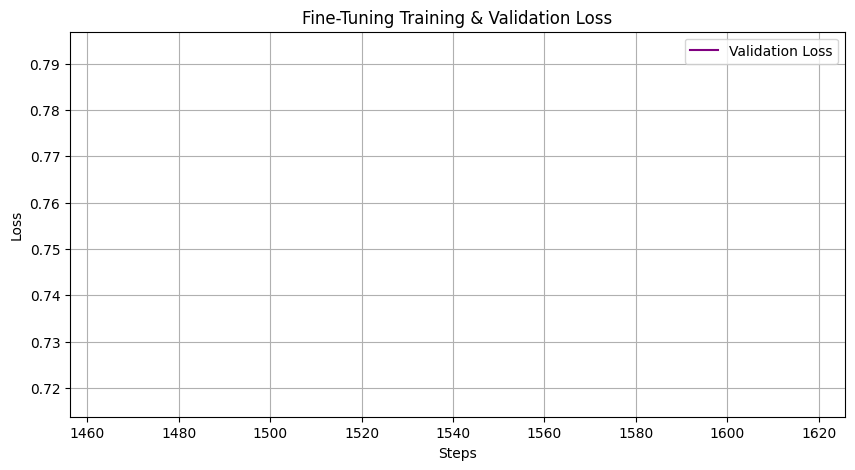

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss over steps
steps = []
training_loss = []
validation_loss = []

# Assign the response from the API call to 'events_response'
events_response = response  # 'response' is from the previous cell

# Process each event
for event in events_response.data:  # events_response.data contains metric events
    event_data = event.data
    if "step" in event_data:
        steps.append(event_data["step"])
        # training_loss.append(event_data.get("train_loss", None))
        validation_loss.append(event_data.get("valid_loss", None))  # Some steps may not have validation loss

# Plot loss curves
plt.figure(figsize=(10, 5))
# plt.plot(steps, training_loss, label="Training Loss", color="green")
plt.plot(steps, validation_loss, label="Validation Loss", color="purple")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Fine-Tuning Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()